<img align="left" src="https://cdn-images-1.medium.com/max/1200/1*iDQvKoz7gGHc6YXqvqWWZQ.png" width="85" height="80" >
<br>

#  Custom Real-Time Object Detection

<br>



This notebook is part of the tutorial [Custom real-time object detection in the browser using TensorFlow.js](https://medium.com/@zaninihugo/custom-real-time-object-detection-in-the-browser-using-tensorflow-js-5ca90538eace) and aims to train a custom Object Detection model using the TensorFlow 2 Object Detection API.

Later, this model is going to be converted to TensorFlow.js  to run directly in a web browser. Refer to the tutorial post to see how.

### Installation

### **Clone and install the Tensorflow Object Detection API** 

In order to use the TensorFlow Object Detection API, we need to clone it's GitHub Repo.
<br>

#### **Dependencies**


Most of the dependencies required come preloaded in Google Colab.  No extra installation is needed.
<br>

#### **Protocol Buffers**



The TensorFlow Object Detection API relies on what are called `protocol buffers` (also known as `protobufs`). Protobufs are a language neutral way to describe information. That means you can write a protobuf once and then compile it to be used with other languages, like Python, Java or C [5].

The `protoc` command used below is compiling all the protocol buffers in the `object_detection/protos` folder for Python.

In [1]:
!git clone https://github.com/tensorflow/models.git

Cloning into 'models'...
remote: Enumerating objects: 74844, done.
remote: Counting objects: 100% (332/332), done.
remote: Compressing objects: 100% (193/193), done.
remote: Total 74844 (delta 189), reused 254 (delta 134), pack-reused 74512
Receiving objects: 100% (74844/74844), 580.48 MiB | 16.79 MiB/s, done.
Resolving deltas: 100% (53059/53059), done.


In [ ]:
%cd /content/models/research/
!protoc object_detection/protos/*.proto --python_out=.
# Install TensorFlow Object Detection API.
!cp object_detection/packages/tf2/setup.py .
!python -m pip install .

/content/models/research
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/models/research
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
     |████████████████████████████████| 10.9 MB 56.8 MB/s 
     |████████████████████████████████| 352 kB 59.2 MB/s 
     |████████████████████████████████| 2.1 MB 57.2 MB/s 
     |████████████████████████████████| 25.9 MB 1.2 MB/s 
     |████████████████████████████████| 67 kB 6.8 MB/s 
     |████████████████████████████████| 1.1 MB 54.6 MB/s 
     |████████████████████████████████| 636 kB 71.7 MB/s 
     |████████████████████████████████|

Run the model builder test

In [ ]:
!python /content/models/research/object_detection/builders/model_builder_tf2_test.py

---

### Getting the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%bash
mkdir /content/dataset
cd /content/dataset
unzip /content/drive/MyDrive/데이터공유폴더/archive.zip

##### Create a `labelmap.pbtxt` file, following the pattern:



```
item {
  name: "kangaroo"
  id: 1
}
```



##### Converting data to TFRecord
The dataset contains two files `train_labels.csv` and `test_labels.csv` which need to be converted into TFRecord format so that it can be fed into Tensorflow’s 2 Object Detection API.

In [ ]:
%cd /content/

/content


In [ ]:
a = '''
item {
  name: "kangaroo"
  id: 1
}
'''
f = open("labelmap.pbtxt", 'w')
f.write(a)
f.close()

In [ ]:
!wget https://raw.githubusercontent.com/hugozanini/object-detection/master/generate_tf_record.py

--2022-06-30 01:06:04--  https://raw.githubusercontent.com/hugozanini/object-detection/master/generate_tf_record.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5076 (5.0K) [text/plain]
Saving to: ‘generate_tf_record.py’

generate_tf_record. 100%[===================>]   4.96K  --.-KB/s    in 0s      

2022-06-30 01:06:04 (66.2 MB/s) - ‘generate_tf_record.py’ saved [5076/5076]



In [ ]:
!python generate_tf_record.py -l labelmap.txt -o dataset/train.record -i dataset/images -csv dataset/train_labels.csv
!python generate_tf_record.py -l labelmap.txt -o dataset/test.record -i dataset/images -csv dataset/test_labels.csv

INFO:Successfully created the TFRecords: dataset/train.record
INFO:Successfully created the TFRecords: dataset/test.record


---

### Configuring train

We are going to use the pretrained TF2 MobileNet V2 model as the feature extractor in the SSD MobileNet V2 Object Detection model. So the next logical step is to download and untar the pretrained TF2 MobileNet V2 model.

#### Downloading MobileNet weights

In [ ]:
%cd /content
!wget http://download.tensorflow.org/models/object_detection/classification/tf2/20200710/mobilenet_v2.tar.gz
!tar -xvf mobilenet_v2.tar.gz
!rm mobilenet_v2.tar.gz

In [ ]:
!wget https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/configs/tf2/ssd_mobilenet_v2_320x320_coco17_tpu-8.config
!mv ssd_mobilenet_v2_320x320_coco17_tpu-8.config mobilenet_v2.config

--2022-06-30 01:07:45--  https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/configs/tf2/ssd_mobilenet_v2_320x320_coco17_tpu-8.config
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4484 (4.4K) [text/plain]
Saving to: ‘ssd_mobilenet_v2_320x320_coco17_tpu-8.config’

ssd_mobilenet_v2_32 100%[===================>]   4.38K  --.-KB/s    in 0s      

2022-06-30 01:07:45 (56.4 MB/s) - ‘ssd_mobilenet_v2_320x320_coco17_tpu-8.config’ saved [4484/4484]



#### Defining training parameters

In [ ]:
num_classes = 1
batch_size = 16 #16
num_steps = 7500 #1500
num_eval_steps = 1000

train_record_path = '/content/dataset/train.record'
test_record_path = '/content/dataset/test.record'
model_dir = '/content/training/'
labelmap_path = '/content/labelmap.pbtxt'

pipeline_config_path = 'mobilenet_v2.config'
fine_tune_checkpoint = '/content/mobilenet_v2/mobilenet_v2.ckpt-1'

#### Editing config file

The next cell is modification of the code available at [4].

In [ ]:
import re

with open(pipeline_config_path) as f:
    config = f.read()

with open(pipeline_config_path, 'w') as f:

  # Set labelmap path
  config = re.sub('label_map_path: ".*?"', 
  'label_map_path: "{}"'.format(labelmap_path), config)
  
  # Set fine_tune_checkpoint path
  config = re.sub('fine_tune_checkpoint: ".*?"',
                  'fine_tune_checkpoint: "{}"'.format(fine_tune_checkpoint),
                  config)
  
  # Set train tf-record file path
  config = re.sub('(input_path: ".*?)(PATH_TO_BE_CONFIGURED/train)(.*?")', 
                  'input_path: "{}"'.format(train_record_path), config)
  
  # Set test tf-record file path
  config = re.sub('(input_path: ".*?)(PATH_TO_BE_CONFIGURED/val)(.*?")', 
                  'input_path: "{}"'.format(test_record_path), config)
  
  # Set number of classes.
  config = re.sub('num_classes: [0-9]+',
                  'num_classes: {}'.format(num_classes), config)
  
  # Set batch size
  config = re.sub('batch_size: [0-9]+',
                  'batch_size: {}'.format(batch_size), config)
  
  # Set training steps
  config = re.sub('num_steps: [0-9]+',
                  'num_steps: {}'.format(num_steps), config)
  
  f.write(config)

---

In [ ]:
!pip uninstall opencv-contrib-python
!pip install opencv-contrib-python

In [ ]:
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following packages will be REMOVED:
  libcudnn8-dev
The following held packages will be changed:
  libcudnn8
The following packages will be upgraded:
  libcudnn8
1 upgraded, 0 newly installed, 1 to remove and 47 not upgraded.
Need to get 430 MB of archives.
After this operation, 3,139 MB disk space will be freed.
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  libcudnn8 8.1.0.77-1+cuda11.2 [430 MB]
Fetched 430 MB in 14s (31.4 MB/s)
(Reading database ... 155639 files and directories currently installed.)
Removing libcudnn8-dev (8.0.5.39-1+cuda11.1) ...
(Reading database ... 155617 files and directories currently installed.)
Preparing to unpack .../libcudnn8_8.1.0.77-1+cuda11.2_amd64.deb ...
Unpacking libcudnn8 (8.1.0.77-1+

### Training the Network

In [ ]:
!python /content/models/research/object_detection/model_main_tf2.py \
    --pipeline_config_path={pipeline_config_path} \
    --model_dir={model_dir} \
    --alsologtostderr \
    --num_train_steps={num_steps} \
    --sample_1_of_n_eval_examples=1 \
    --num_eval_steps={num_eval_steps}

2022-06-30 01:09:35.171407: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
I0630 01:09:35.299607 140002289334144 mirrored_strategy.py:374] Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Maybe overwriting train_steps: 7500
I0630 01:09:35.303429 140002289334144 config_util.py:552] Maybe overwriting train_steps: 7500
INFO:tensorflow:Maybe overwriting use_bfloat16: False
I0630 01:09:35.303607 140002289334144 config_util.py:552] Maybe overwriting use_bfloat16: False
Instructions for updating:
rename to distribute_datasets_from_function
W0630 01:09:35.340483 140002289334144 deprecation.py:356] From /usr/local/lib/python3.7/dist-packages/object_detection/model_lib_v2.py:564: StrategyBase.experimental

---

### Validation

Here we're going yo run the code through a loop that waits for checkpoints to evaluate. Once the evaluation finishes, you're going to see the message:

`INFO:tensorflow:Waiting for new checkpoint at /content/training/`

Then you can stop the cell


In [ ]:
!python /content/models/research/object_detection/model_main_tf2.py \
    --pipeline_config_path={pipeline_config_path} \
    --model_dir={model_dir} \
    --checkpoint_dir={model_dir}           ##This is passed to run ONLY EVALUATION

---

### Training and validation Metrics 

In [ ]:
%load_ext tensorboard
%tensorboard --logdir '/content/training/'

### Export the Inference Graph

The below code cell adds a line to the tf_utils.py file. This is a temporary fix to a exporting issue occuring when using the OD API with Tensorflow 2. This code will be removed as soon as the OD Team puts out a fix.

All credit goes to the Github users [Jacobsolawetz](https://github.com/Jacobsolawetz) and [ Tanner Gilbert](https://github.com/TannerGilbert), who provided this [temporary fix](https://github.com/tensorflow/models/issues/8841#issuecomment-657647648).

In [ ]:
# with open('/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/tf_utils.py') as f:
#     tf_utils = f.read()

# with open('/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/tf_utils.py', 'w') as f:
#   # Set labelmap path
#   throw_statement = "raise TypeError('Expected Operation, Variable, or Tensor, got ' + str(x))"
#   tf_utils = tf_utils.replace(throw_statement, "if not isinstance(x, str):" + throw_statement)
#   f.write(tf_utils)

In [ ]:
output_directory = 'inference_graph'

!python /content/models/research/object_detection/exporter_main_v2.py \
    --trained_checkpoint_dir {model_dir} \
    --output_directory {output_directory} \
    --pipeline_config_path {pipeline_config_path}

2022-06-30 01:56:52.399886: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.map_fn(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(fn, elems))
W0630 01:56:52.549723 140438829471616 deprecation.py:628] From /usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:458: calling map_fn_v2 (from tensorflow.python.ops.map_fn) with back_prop=False is deprecated and will be removed in a future version.
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.map_fn(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(fn, elems))
INFO:tensorflow:depth of additional

##### Downloading weights

In [ ]:
!zip -r /content/saved_model.zip /content/inference_graph/saved_model/

  adding: content/inference_graph/saved_model/ (stored 0%)
  adding: content/inference_graph/saved_model/saved_model.pb (deflated 92%)
  adding: content/inference_graph/saved_model/variables/ (stored 0%)
  adding: content/inference_graph/saved_model/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/inference_graph/saved_model/variables/variables.index (deflated 76%)
  adding: content/inference_graph/saved_model/assets/ (stored 0%)


In [ ]:
from google.colab import files
files.download("/content/saved_model.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

---

###  Testing the trained model

Based on [Object Detection API Demo](https://github.com/tensorflow/models/blob/master/research/object_detection/colab_tutorials/object_detection_tutorial.ipynb) and [Inference from saved model tf2 colab](https://github.com/tensorflow/models/blob/master/research/object_detection/colab_tutorials/inference_from_saved_model_tf2_colab.ipynb).

In [ ]:
!wget https://raw.githubusercontent.com/hugozanini/object-detection/master/inferenceutils.py
from inferenceutils import *

--2022-06-30 01:58:50--  https://raw.githubusercontent.com/hugozanini/object-detection/master/inferenceutils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2219 (2.2K) [text/plain]
Saving to: ‘inferenceutils.py’

inferenceutils.py   100%[===================>]   2.17K  --.-KB/s    in 0s      

2022-06-30 01:58:50 (50.0 MB/s) - ‘inferenceutils.py’ saved [2219/2219]



##### Loading the model

In [ ]:
output_directory = 'inference_graph/'

In [ ]:
category_index = label_map_util.create_category_index_from_labelmap(labelmap_path, use_display_name=True)
tf.keras.backend.clear_session()
model = tf.saved_model.load(f'/content/{output_directory}/saved_model')

##### Selecting the images to test

In [ ]:
import pandas as pd
test = pd.read_csv('dataset/test_labels.csv')
images = list(test['filename'][0:5])

##### Doing inference

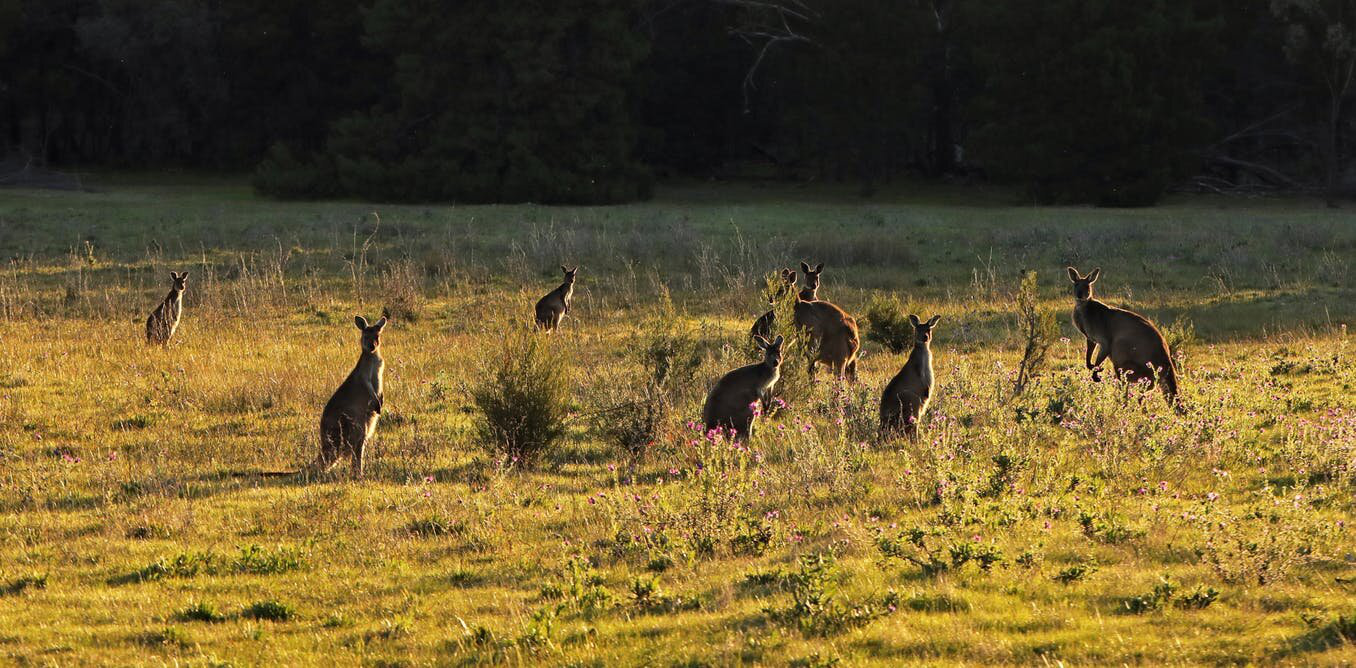

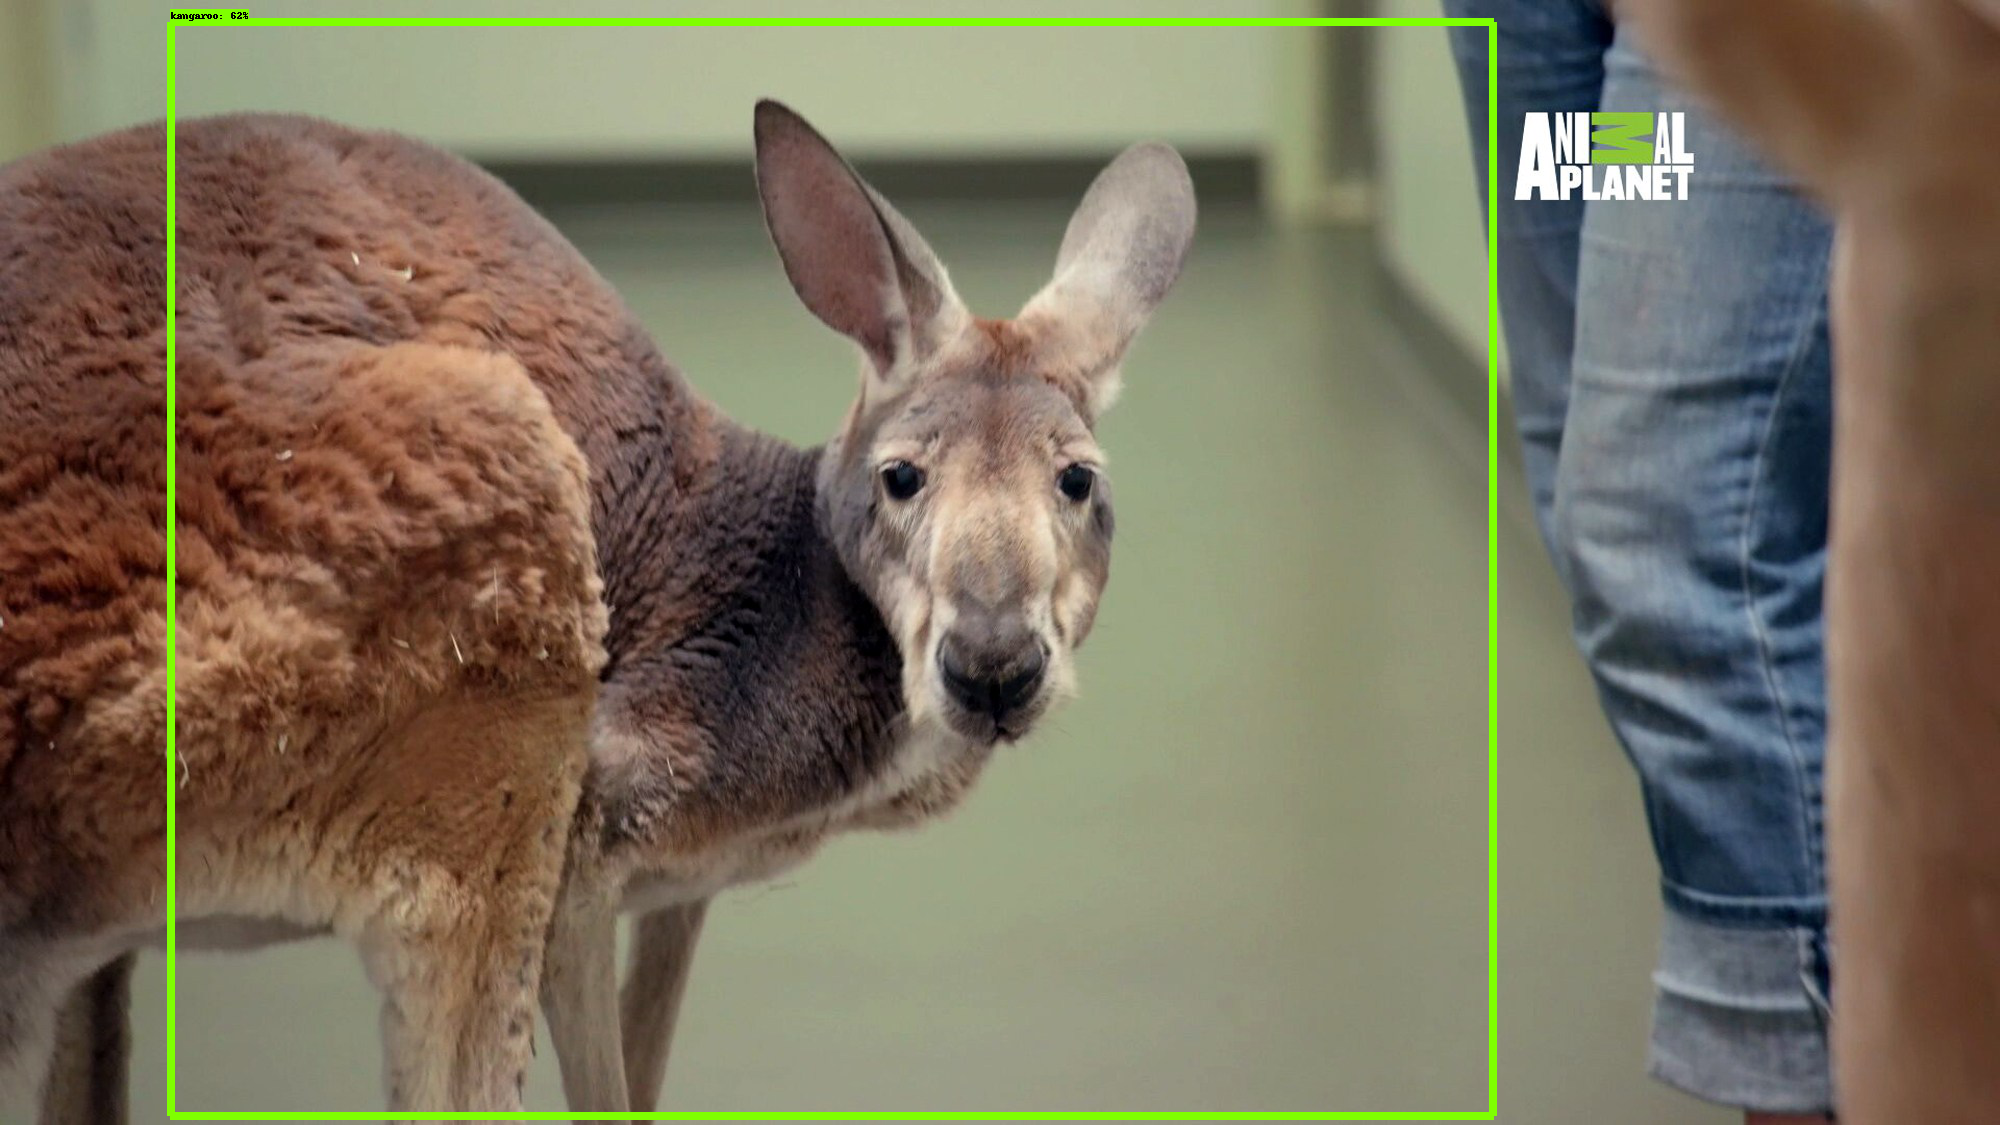

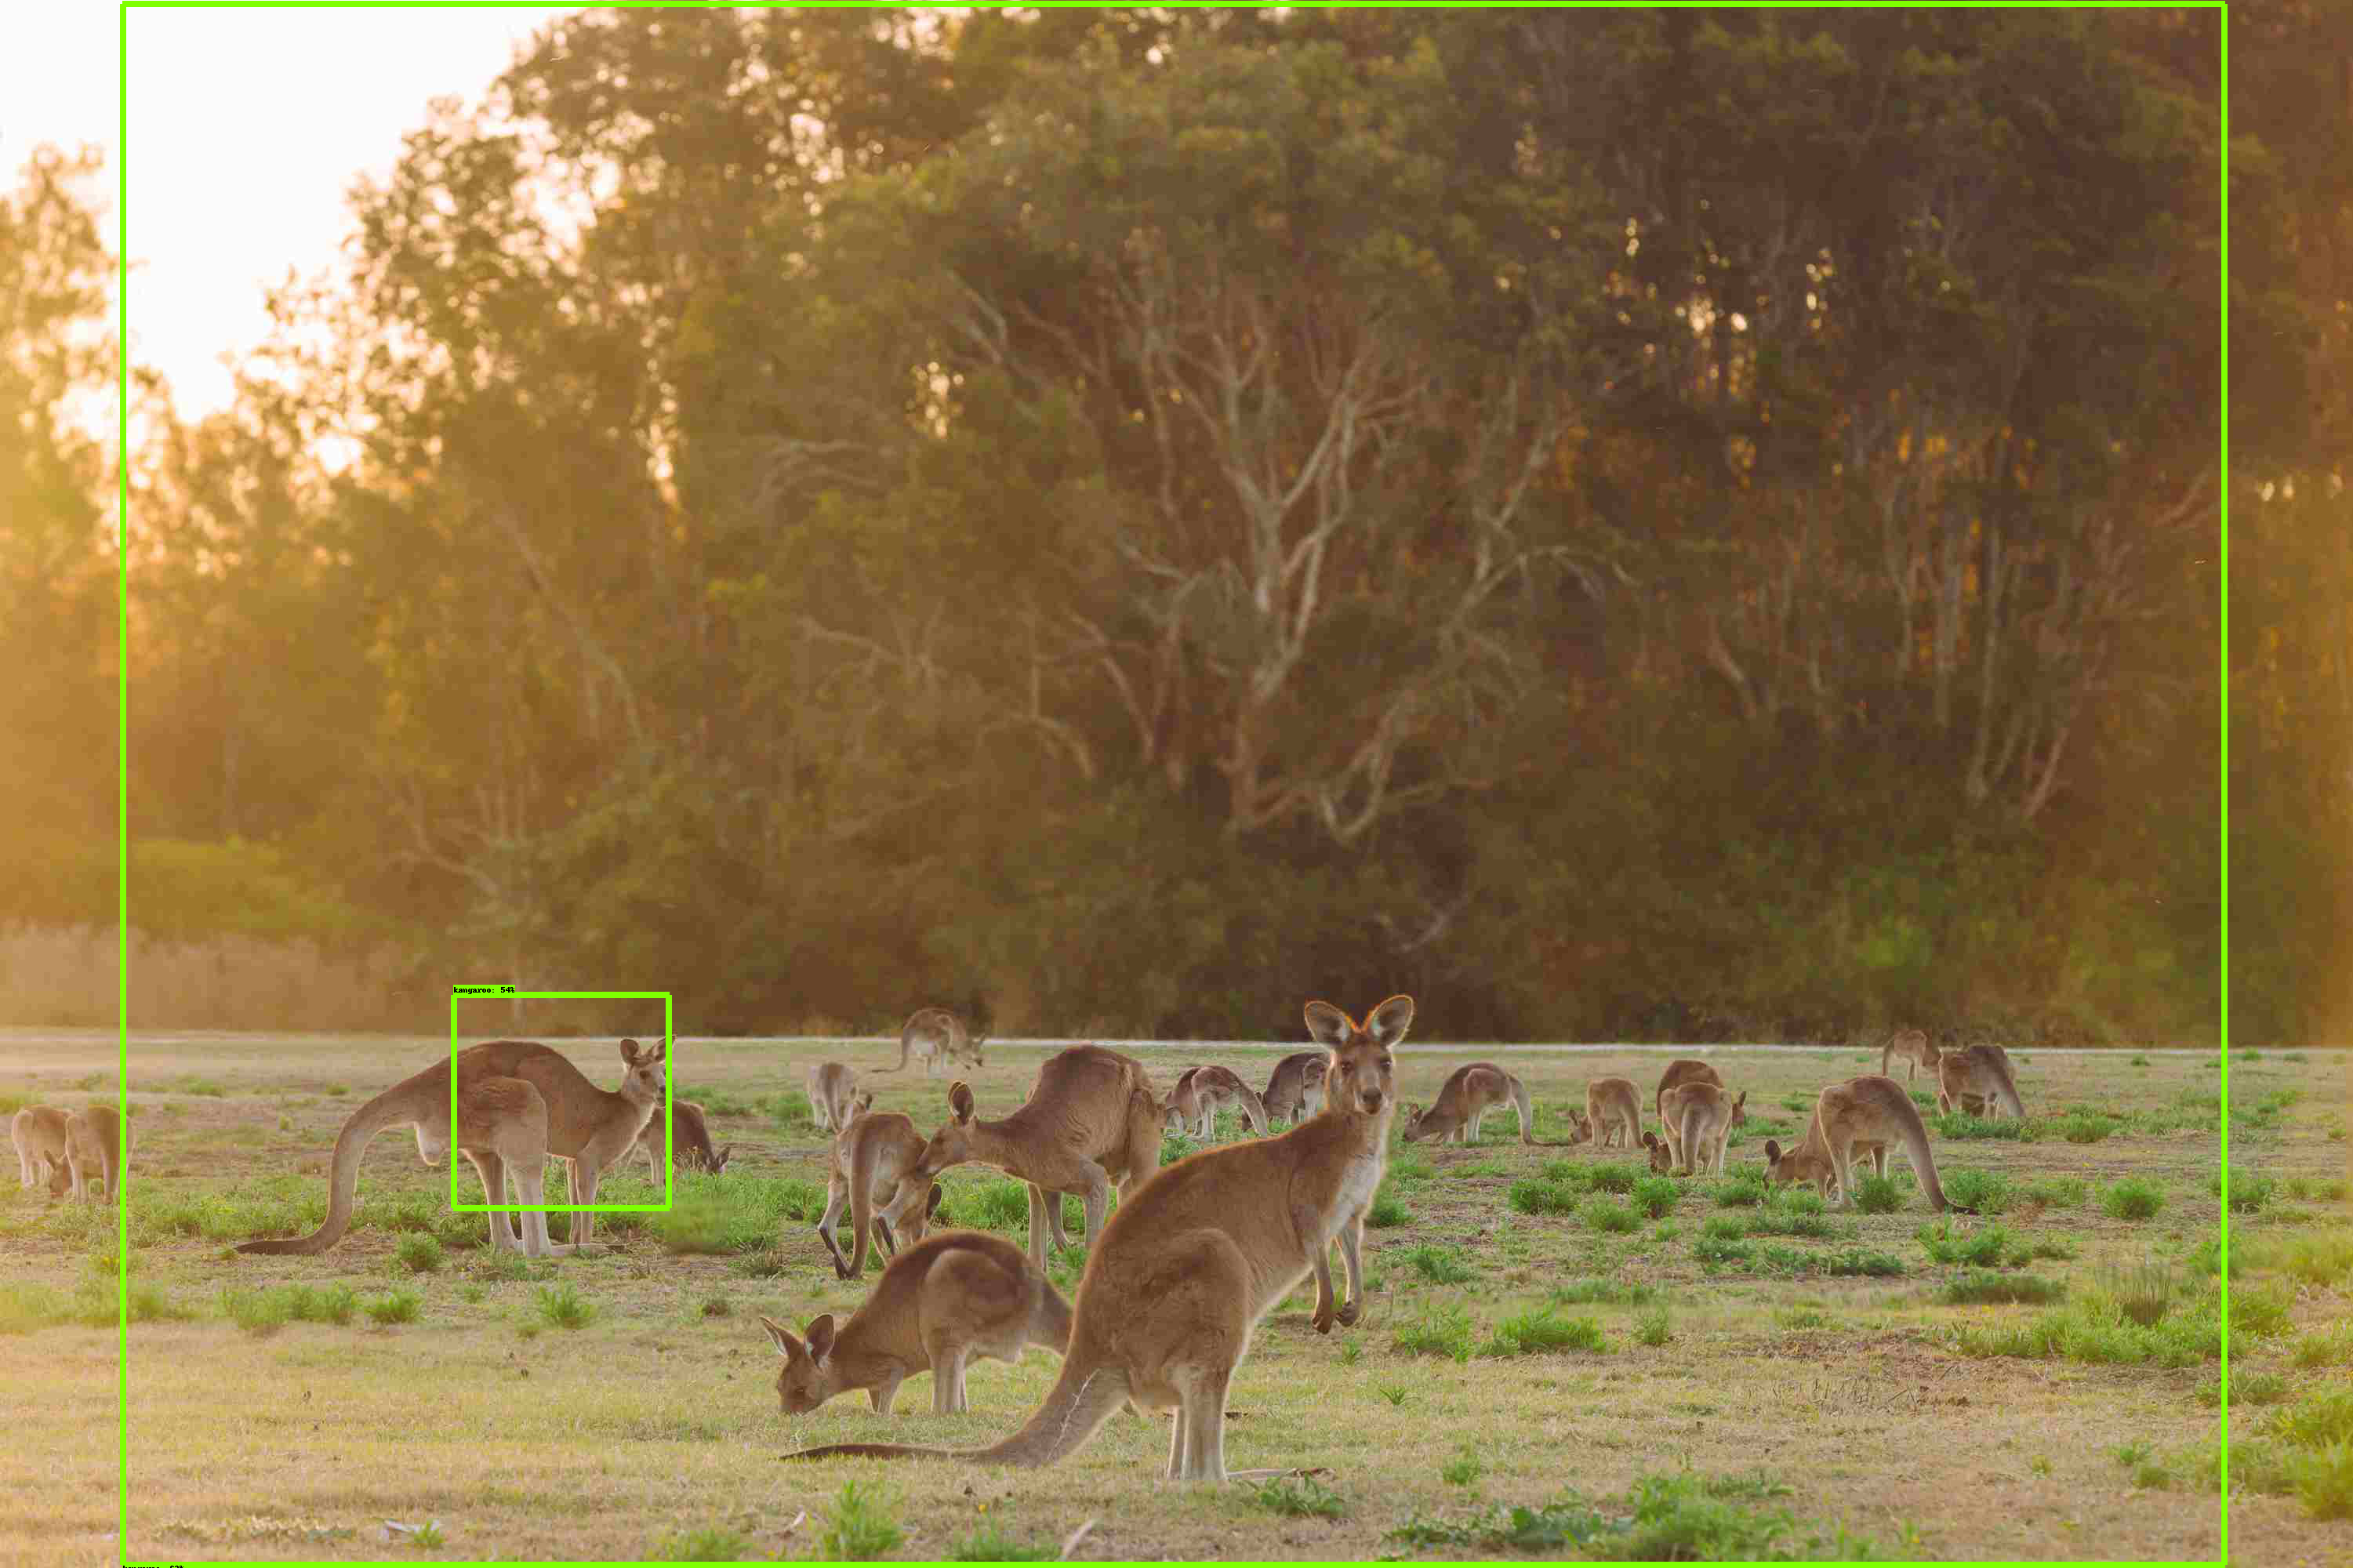

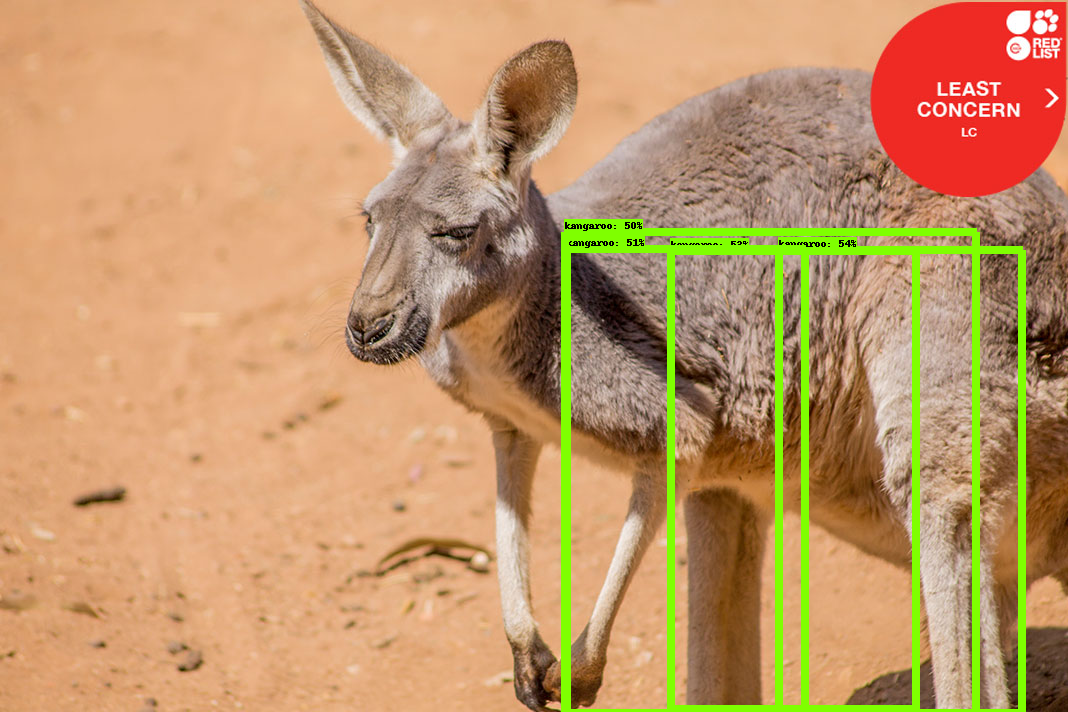

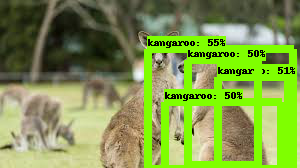

In [ ]:
# images = ['canguru-1.jpeg', 'canguru-2.jpeg', 'canguru-3.jpeg']

for image_name in images:
  
  image_np = load_image_into_numpy_array('dataset/images/' + image_name)
  output_dict = run_inference_for_single_image(model, image_np)
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks_reframed', None),
      use_normalized_coordinates=True,
      line_thickness=8)
  display(Image.fromarray(image_np))

---

##Web model 

In [ ]:
!pip 

In [ ]:
!tensorflowjs_converter \
    --input_format=tf_saved_model \
    --output_format=tfjs_graph_model \
    --signature_name=serving_default \
    --saved_model_tags=serve \
    /content/inference_graph/saved_model \
    /content/web_model_2

2022-06-30 02:17:23.476358: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
Writing weight file /content/web_model_2/model.json...


In [ ]:
!zip -r /content/web_model_2.zip /content/web_model_2/

  adding: content/web_model_2/ (stored 0%)
  adding: content/web_model_2/group1-shard3of5.bin (deflated 7%)
  adding: content/web_model_2/group1-shard2of5.bin (deflated 7%)
  adding: content/web_model_2/group1-shard1of5.bin (deflated 7%)
  adding: content/web_model_2/group1-shard4of5.bin (deflated 6%)
  adding: content/web_model_2/group1-shard5of5.bin (deflated 7%)
  adding: content/web_model_2/model.json (deflated 96%)


In [ ]:
from google.colab import files
files.download("/content/web_model_2.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### References

[0] Tanner, G. (2020, July 27). Tensorflow Object Detection with Tensorflow 2: Creating a custom model. Retrieved December 28, 2020, from https://gilberttanner.com/blog/tensorflow-object-detection-with-tensorflow-2-creating-a-custom-model

---

[1] Rafiq, H. (2020, December 13). Image Object Detection - TensorFlow 2 Object Detection API. Retrieved December 28, 2020, from https://medium.com/swlh/image-object-detection-tensorflow-2-object-detection-api-af7244d4c34e

---

[2] TensorFlow 2 Detection Model Zoo. (2020, September 09). Tensorflow/models. Retrieved December 28, 2020, from https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md

---

[3] Tensorflow 2 Models Configs. (2020, August 11). Tensorflow/models. Retrieved December 28, 2020, from https://github.com/tensorflow/models/tree/master/research/object_detection/configs/tf2

---
[4] Solawetz, J. (2020, December 09). How to Train YOLOv4 on a Custom Dataset. Retrieved December 28, 2020, from https://blog.roboflow.com/training-yolov4-on-a-custom-dataset/

---

[5] Google Colaboratory. (n.d.). Retrieved January 13, 2021, from https://colab.research.google.com/github/cloud-annotations/google-colab-training/blob/master/object_detection.ipynb#:~:text=The%20TensorFlow%20Object%20Detection%20API%20relies%20on%20what%20are%20called,like%20Python%2C%20Java%20or%20C.
